# Tutorial 1.4: Cross scales experiments for pip flow

- **Authors**: Xiaoyu Xie
- **Contact**: xiaoyuxie2020@u.northwestern.edu

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/xiaoyuxie-vico/PyDimension-Book/blob/main/examples/cross_scales.ipynb)
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/xiaoyuxie-vico/PyDimension-Book/HEAD)

## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import matrix_rank
from numpy.linalg import inv
import pandas as pd
import pysindy as ps
import random
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from scipy.optimize import minimize
import xgboost
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline
plt.rcParams["font.family"] = 'Arial'
np.set_printoptions(suppress=True)

In [2]:
np.random.seed(0)

param_list = ['mu', 'l', 'v', 'rho', 'p', 'Re']
train_num, test_num = 100, 100

# training set: small l
res = []
Re_min, Re_max = 0, 0
for _ in range(train_num):
    mu = np.random.randint(1, 100) / 1e4
    l = np.random.randint(1, 10) / 10
    v = np.random.randint(100, 1000)
    rho = np.random.randint(1, 10) / 1e3
    p = np.random.randint(1, 10) * 1e4
    Re  = rho * v * l / mu
    if Re < Re_min: 
        Re_min = Re
    if Re > Re_max: 
        Re_max = Re
    res.append([mu, l, v, rho, p, Re, 'Train'])

# test set: large l
while True:
    mu = np.random.randint(1, 100) / 1e5
    l = np.random.randint(100, 1000) / 10 # large l
    v = np.random.randint(1, 10)
    rho = np.random.randint(1, 10) / 1e4
    p = np.random.randint(1, 10) * 1e4
    Re  = rho * v * l / mu
    
    if Re < Re_min or Re > Re_max:
        continue
    res.append([mu, l, v, rho, p, Re, 'Test'])
    if len(res) >= test_num + train_num:
        break

df = pd.DataFrame(res, columns=['mu', 'l', 'v', 'rho', 'p', 'Re', 'data_source'])
print(df.head())
print('Re_min, Re_max', Re_min, Re_max)

       mu    l    v    rho        p           Re data_source
0  0.0045  0.6  292  0.004  40000.0   155.733333       Train
1  0.0010  0.4  377  0.003  50000.0   452.400000       Train
2  0.0088  0.7  572  0.009  20000.0   409.500000       Train
3  0.0040  0.8  274  0.009  20000.0   493.200000       Train
4  0.0038  0.9  877  0.005  40000.0  1038.552632       Train
Re_min, Re_max 0 6675.749999999999


In [3]:
# train_val set
df_train_val =  df[df['data_source']=='Train']
data_train_val = df_train_val[['mu', 'l', 'v', 'rho', 'p', 'Re']].to_numpy()

# test set
df_test =  df[df['data_source']=='Test']
data_test = df_test[['mu', 'l', 'v', 'rho', 'p', 'Re']].to_numpy()

# add gaussian noise
noise_level = 0.0
for i in range(data_train_val.shape[1]):
    data_train_val[:, i] += noise_level * np.std(data_train_val[:, i]) * np.random.randn(train_num,)
    data_test[:, i] += noise_level * np.std(data_test[:, i]) * np.random.randn(test_num,)

# split input and output
X_train_val = data_train_val[:, :-1]
y_train_val = data_train_val[:, -1].reshape(-1,1)
X_test = data_test[:, :-1]
y_test = data_test[:, -1].reshape(-1,1)

# noisy df
df_train_noise = pd.DataFrame(data_train_val, columns=['mu', 'l', 'v', 'rho', 'p', 'Re'])
df_train_noise.describe()

,mu,l,v,rho,p,Re
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.005335,0.470000,558.750000,0.004960,50400.000000,462.776547
std,0.002612,0.245567,246.118038,0.002723,26243.613942,924.212221
min,0.000400,0.100000,113.000000,0.001000,10000.000000,7.000000
25%,0.003200,0.300000,341.250000,0.003000,30000.000000,68.403846
50%,0.005400,0.500000,554.000000,0.005000,50000.000000,162.686499
75%,0.007300,0.700000,777.750000,0.007250,70000.000000,462.272973
max,0.009700,0.900000,999.000000,0.009000,90000.000000,6675.750000


In [4]:
class DimensionlessLearning(object):
    '''
    Indentify the explicit form one coefficient using dimensionless learning
    '''
    
    def __init__(self, df, input_list, output_coef, dimension_info, basis_list):
        super(DimensionlessLearning, self).__init__()
        self.df = df
        self.input_list = input_list
        self.output_coef = output_coef
        self.X, self.y = self.prepare_dataset()
        self.dimension_info, self.basis_list = dimension_info, basis_list
        self.basis1_in, self.basis2_in = self.prepare_dimension()

    def prepare_dataset(self):
        '''
        prepare the input and output data
        '''
        X = self.df[self.input_list].to_numpy()
        y = self.df[self.output_coef].to_numpy().reshape(-1, 1)
        return X, y
        
    def prepare_dimension(self):
        '''
        parse dimension for input and output
        '''
        basis1_in, basis2_in = self.basis_list[0], self.basis_list[1]
        return basis1_in, basis2_in

    def fetch_coef_pi(self, coef):
        '''
        parse the combined weights for the input
        '''
        coef_pi = coef[0] * self.basis1_in + coef[1] * self.basis2_in
        return coef_pi
        
    def check_dimension(self, coef):
        '''
        check whether the basis vectors can formulated as the D_out
        '''
        coef_pi = self.fetch_coef_pi(coef)
        # print('[check] coef_pi: \n', coef_pi)
        target_D_out = np.dot(self.dimension_info[0], coef_pi)
        # print('[check] target_D_out: \n', target_D_out)
        assert np.array_equal(target_D_out, self.dimension_info[1]), 'Wrong target_D_out!'

    def predict(self, X):
        '''
        Predict
        '''
        pi_in = np.prod(np.power(X, self.gamma.reshape(-1,)), axis=1).reshape(-1, 1)
        pred = pi_in * self.beta
        return pred

    def fit_pattern_search(self, seed):
        '''
        pattern search
        '''
        def get_coordinates(a, b, delta):
            '''
            Build a list to store all possible coordiantes
            '''
            coord_all = []
            for a_ in [a-delta, a, a+delta]:
                for b_ in [b-delta, b, b+delta]:
                    if [a_, b_] != [a, b]:
                        coord_all.append([a_, b_])
            return coord_all
        
        def opt(coef):
            '''
            fit a linear regression
            '''
            coef_pi = self.fetch_coef_pi(coef)
            pi_in = np.prod(np.power(self.X, coef_pi.reshape(-1,)), axis=1).reshape(-1, 1)
            reg =LinearRegression(fit_intercept=False)
            reg.fit(pi_in, self.y)
            y_pred = reg.predict(pi_in)
            r2 = r2_score(self.y, y_pred)
            return r2, coef_pi, reg.coef_

        np.random.seed(seed)
        res, break_points = [], []
        a = np.random.choice(np.linspace(-2, 2, 9), 1)[0]  # [-2, 2] delta=0.5
        b = np.random.choice(np.linspace(-2, 2, 9), 1)[0]  # [-2, 2] delta=0.5
        coef = np.array([a, b]).reshape(-1, 1)

        iter_num, max_iter, delta = 0, 10, 0.5
        while iter_num < max_iter:
            candidate_coord = get_coordinates(a, b, delta)
            r2_center, reg_coef_center, coef_w_center = opt(coef)
            # print('r2_center', round(r2_center, 2), 'reg_coef_center', [round(each, 2) for each in list(reg_coef_center.reshape(-1,))])
            # print('coef_w_center', coef_w_center)

            if r2_center < 0.2:
                break_points.append([a, b])
                break

            r2_bounds_val = []
            for [a_, b_] in candidate_coord:
                coef_temp = np.array([a_, b_]).reshape(-1, 1)
                r2_bound, reg_coef_bound, coef_w_bound = opt(coef_temp)
                r2_bounds_val.append(r2_bound)

            # sort r2 from high to low
            highest_index = np.argsort(r2_bounds_val)[::-1][0]
            iter_num += 1

            # udpate the center coordiantes when the R2 in the neighborhood is higher
            if r2_center < r2_bounds_val[highest_index]:
                [a, b] = candidate_coord[highest_index]
                coef = np.array([a, b]).reshape(-1, 1)
                coef_pi = self.fetch_coef_pi(coef)
                res_info = {'a': a, 'b': b, 'r2_center': round(r2_bounds_val[highest_index], 4)}
                # print('update', res_info)
                res.append(res_info)
            else:
                break
        
        coef_pi = self.fetch_coef_pi(coef)
        r2, reg_coef_final, coef_w_final = opt(coef)
        self.gamma, self.beta = reg_coef_final, int(round(coef_w_final[0][0], 0))

        return r2, reg_coef_final, coef_w_final

In [5]:
# Dimensionless learning
input_list = ['mu', 'l', 'v', 'rho', 'p']
output_coef = 'Re'

D_in = np.mat('-1, -1, 1; 1, 0, 0; 1, -1, 0; -3, 0, 1; -1, -2, 1').T
D_out = np.mat('0;, 0; 0')
dimension_info = [D_in, D_out]

basis1_in = np.array([-1, 1, 1, 1, 0]).reshape(-1, 1)
basis2_in = np.array([-1, 1, -1, 0, 1]).reshape(-1, 1)
basis_list = [basis1_in, basis2_in]

# cross-validation
model_name_list = ['dimensionless_learning'] * 5
r2_train_list, r2_val_list, r2_tes_list = [], [], []
# ss = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
ss = KFold(n_splits=5, random_state=0, shuffle=True)

for train_index, val_index in ss.split(data_train_val):

    X_train, y_train = data_train_val[train_index, :-1], data_train_val[train_index, -1].reshape(-1, 1)
    X_val, y_val = data_train_val[val_index, :-1], data_train_val[val_index, -1].reshape(-1, 1)
    df_train_temp = pd.DataFrame(data_train_val, columns=['mu', 'l', 'v', 'rho', 'p', 'Re'])

    for seed in range(5):
        dimensionless_learning = DimensionlessLearning(df_train_temp, input_list, output_coef, dimension_info, basis_list)
        r2, coef, coef_w = dimensionless_learning.fit_pattern_search(seed=seed)
        if r2 < 0.8:
            continue
        # print('final r2', r2, coef.flatten(), coef_w)
        y_train_pred = dimensionless_learning.predict(X_train)
        y_val_pred = dimensionless_learning.predict(X_val)
        y_test_pred = dimensionless_learning.predict(X_test)
        r2_train, r2_val, r2_test = r2_score(y_train, y_train_pred), r2_score(y_val, y_val_pred), r2_score(y_test, y_test_pred)
        print(f'r2_train: {r2_train:.4f}, r2_val: {r2_val:.4f}, r2_test: {r2_test:.4f}')
        r2_train_list.append(r2_train), r2_val_list.append(r2_val), r2_tes_list.append(r2_test)
        break

df_dimension = pd.DataFrame(np.array([model_name_list, r2_train_list, r2_val_list, r2_tes_list]).T, columns=['model_name', 'Train', 'Val', 'Test'])
print(df_dimension)

r2_train: 1.0000, r2_val: 1.0000, r2_test: 1.0000
r2_train: 1.0000, r2_val: 1.0000, r2_test: 1.0000
r2_train: 1.0000, r2_val: 1.0000, r2_test: 1.0000
r2_train: 1.0000, r2_val: 1.0000, r2_test: 1.0000
r2_train: 1.0000, r2_val: 1.0000, r2_test: 1.0000
               model_name Train  Val Test
0  dimensionless_learning   1.0  1.0  1.0
1  dimensionless_learning   1.0  1.0  1.0
2  dimensionless_learning   1.0  1.0  1.0
3  dimensionless_learning   1.0  1.0  1.0
4  dimensionless_learning   1.0  1.0  1.0


In [6]:
# normalization
scaler = StandardScaler()
X_train_val_transformed = scaler.fit_transform(X_train_val)
X_test_transformed = scaler.transform(X_test)

y_train_val_transformed = scaler.fit_transform(y_train_val)
y_test_transformed = scaler.transform(y_test)

In [7]:
def train_eval(model_name, para_grids):
    '''
    Cross-validation and evaluate on the test set
    '''
    # GridSearchCV to search the best parameters for the model
    estimator = eval(f'{model_name}()')
    grid = GridSearchCV(estimator, para_grids, scoring='r2', cv=5)
    grid.fit(X_train_val_transformed, y_train_val_transformed)
    # best_model = grid.best_estimator_
    print(f'model_name: {model_name}')
    print(f'best_params:{grid.best_params_}')
    model_name_list = [model_name] * 5

    # cross-validation
    # ss = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    ss = KFold(n_splits=5, random_state=0, shuffle=True)
    r2_train_list, r2_val_list, r2_tes_list = [], [], []
    for train_index, val_index in ss.split(X_train_val_transformed):
        model = eval(f'{model_name}(**grid.best_params_)')
        X_train, y_train = X_train_val_transformed[train_index, :], y_train_val_transformed[train_index]
        X_val, y_val = X_train_val_transformed[val_index, :], y_train_val_transformed[val_index]
        model.fit(X_train, y_train)
        r2_train, r2_val, r2_test = model.score(X_train, y_train), model.score(X_val, y_val), model.score(X_test_transformed, y_test_transformed)
        print(f'r2_train: {r2_train:.4f}, r2_val: {r2_val:.4f}, r2_test: {r2_test:.4f}')
        r2_train_list.append(r2_train), r2_val_list.append(r2_val), r2_tes_list.append(r2_test)

    df = pd.DataFrame(np.array([model_name_list, r2_train_list, r2_val_list, r2_tes_list]).T, columns=['model_name', 'Train', 'Val', 'Test'])
    return df

In [8]:
# key: model_name, value: para_grids
configs = {
    'LinearRegression': {},
    'xgboost.XGBRegressor': {
        'n_estimators': [20, 50, 80], 
        'max_depth': [5, 10, 20],
        'seed': [0],
    },
    'RandomForestRegressor': {
        'n_estimators' : [10, 50, 100, 200], 
        'max_features' : ['auto', 'log2', 'sqrt'], 
        'bootstrap' : [True, False], 
        'random_state': [0]
    },
    'KNeighborsRegressor': {
        'n_neighbors': [2, 3, 4, 5],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    },
    'MLPRegressor': {
        'hidden_layer_sizes': [(100, 100, 100), (50, 100, 50)], 
        'alpha': [0.00005, 0.0005],
        'max_iter': [200, 500, 800],
        'learning_rate': ['constant','adaptive'],
        'random_state': [0],
    },
}

In [9]:
# combine different models' results
res = []
for model_name, para_grids in configs.items():
    res_each = train_eval(model_name, para_grids)
    res.append(res_each)
res.append(df_dimension)
res_all = pd.concat(res)
res_all = res_all.astype({'Train': 'float64', 'Val': 'float64', 'Test': 'float64'})
res_all.head()

model_name: LinearRegression
best_params:{}
r2_train: 0.5795, r2_val: 0.3579, r2_test: -4806.4307
r2_train: 0.4846, r2_val: 0.5539, r2_test: -4165.5951
r2_train: 0.5216, r2_val: -0.4441, r2_test: -4273.3456
r2_train: 0.5218, r2_val: -2.4113, r2_test: -4526.2871
r2_train: 0.4463, r2_val: 0.5926, r2_test: -1681.6184


model_name: xgboost.XGBRegressor
best_params:{'max_depth': 5, 'n_estimators': 20, 'seed': 0}
r2_train: 0.9989, r2_val: 0.6572, r2_test: -3.5887
r2_train: 0.9986, r2_val: 0.8858, r2_test: -4.7738
r2_train: 0.9986, r2_val: -6.8117, r2_test: -7.3723
r2_train: 0.9990, r2_val: 0.6682, r2_test: -0.1385
r2_train: 0.9987, r2_val: 0.5682, r2_test: -0.3198


model_name: RandomForestRegressor
best_params:{'bootstrap': True, 'max_features': 'log2', 'n_estimators': 50, 'random_state': 0}
r2_train: 0.9598, r2_val: 0.4355, r2_test: -1.2620
r2_train: 0.9169, r2_val: 0.8328, r2_test: -3.5448
r2_train: 0.9492, r2_val: -1.1425, r2_test: -2.1319
r2_train: 0.9232, r2_val: 0.3504, r2_test: -3.9884


r2_train: 0.9015, r2_val: 0.4521, r2_test: -0.8882
model_name: KNeighborsRegressor
best_params:{'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'uniform'}
r2_train: 0.5795, r2_val: 0.2885, r2_test: -1.7152
r2_train: 0.5438, r2_val: 0.3044, r2_test: -0.9803
r2_train: 0.5395, r2_val: 0.7173, r2_test: -1.1356
r2_train: 0.5478, r2_val: 0.6223, r2_test: -1.6572
r2_train: 0.4758, r2_val: 0.5147, r2_test: -0.0160


model_name: MLPRegressor
best_params:{'alpha': 0.0005, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'max_iter': 200, 'random_state': 0}
r2_train: 0.9968, r2_val: 0.5143, r2_test: -7006.4066
r2_train: 0.9988, r2_val: 0.5482, r2_test: -8867.2314


r2_train: 0.9991, r2_val: 0.1623, r2_test: -26856.3159
r2_train: 0.9993, r2_val: 0.8097, r2_test: -12370.9716
r2_train: 0.9993, r2_val: 0.7119, r2_test: -5617.2697


,model_name,Train,Val,Test
0,LinearRegression,0.579519,0.357872,-4806.430687
1,LinearRegression,0.484566,0.553903,-4165.595128
2,LinearRegression,0.521640,-0.444123,-4273.345576
3,LinearRegression,0.521824,-2.411334,-4526.287068
4,LinearRegression,0.446318,0.592597,-1681.618358


In [10]:
model_name_map = {
    'dimensionless_learning': 'Proposed \nmethod',
    'RandomForestRegressor': 'RF',
    'MLPRegressor': 'FFNN',
    'LinearRegression': 'LR',
    'KNeighborsRegressor': 'KNN',
    'xgboost.XGBRegressor': 'XGBoost',
}

res_final = []
for i in range(res_all.shape[0]):
    each_row = res_all.iloc[i]
    model_name = model_name_map[each_row['model_name']]
    res_final.append([model_name, float(each_row['Train']), 'Training set'])
    res_final.append([model_name, float(each_row['Val']), 'Validation set'])
    res_final.append([model_name, float(each_row['Test']), 'Test set'])

df_final = pd.DataFrame(res_final, columns=['Model_name', 'R2', 'Data source'])
df_final.head()

,Model_name,R2,Data source
0,LR,0.579519,Training set
1,LR,0.357872,Validation set
2,LR,-4806.430687,Test set
3,LR,0.484566,Training set
4,LR,0.553903,Validation set


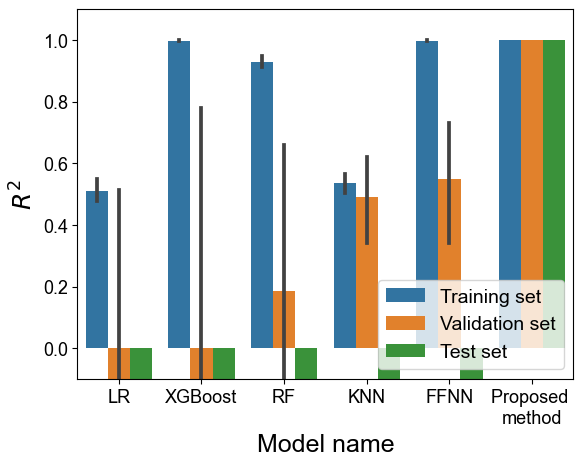

In [11]:
fig = plt.figure()
sns.barplot(data=df_final, x='Model_name', y='R2', hue='Data source')
plt.ylim([-0.1, 1.1])
plt.legend(fontsize=14, loc=4)
plt.xlabel('Model name', fontsize=18)
plt.ylabel(r'$R^2$', fontsize=18)
plt.tick_params(labelsize=13)
plt.show()